In [ ]:
#Importing libraries
import pandas as pd
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import numpy as np
import sdt.changepoint as c
import math

In [ ]:
#import ARIMA libraries
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np

In [ ]:
# create a dataframe from the csv file
df_new_cases = pd.read_csv('../data/WHO-COVID-19-global-data.csv')
#df_vaccination = pd.read_csv('../data/owid-covid-data.csv')
df_vaccination = pd.read_csv('../data/country_vaccinations.csv')

In [ ]:
# add moving average for new cases
#df_vaccination['moving_average_new_vaccinations'] = df_vaccination.groupby('iso_code')['new_vaccinations'].transform(lambda x: x.rolling(window=7).mean()) # OWID
df_vaccination['moving_average_new_vaccinations'] = df_vaccination.groupby('iso_code')['daily_vaccinations'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_vaccination = df_vaccination.dropna(subset=['moving_average_new_vaccinations'])
df_vaccination = df_vaccination[df_vaccination['moving_average_new_vaccinations'] != 0.0]

In [ ]:
# add moving average for new cases
df_new_cases['moving_average_new_cases'] = df_new_cases.groupby('Country_code')['New_cases'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_new_cases = df_new_cases.dropna(subset=['moving_average_new_cases'])
df_new_cases = df_new_cases[df_new_cases['moving_average_new_cases'] != 0.0]

In [ ]:
# firter data from 2021-07-16 to 2021-08-15
start_date = date(2021, 1, 1) 
og_start_date = date(2021, 7, 22)
og_end_date = date(2021, 8, 8)
end_date = date(2021, 8, 23)

difference = og_start_date - start_date
event_duration = og_end_date - og_start_date

# filter data from 2021-07-16 to 2021-08-15
#df_new_cases = df_new_cases[(df_new_cases['Date_reported'] >= str(start_date)) & (df_new_cases['Date_reported'] <= str(end_date))]

# filter df_vaccination from 2021-07-16 to 2021-08-15
#df_vaccination = df_vaccination[(df_vaccination['date'] >= str(start_date)) & (df_vaccination['date'] <= str(end_date))]


# filter df_vaccination and df_new_cases from 2020-12-08 to 2021-08-31
start_vaccination = date(2020, 12, 8)
end_study = date(2021, 8, 23)
df_vaccination = df_vaccination[(df_vaccination['date'] >= str(start_vaccination)) & (df_vaccination['date'] <= str(end_study))]
df_vaccination = df_vaccination.reset_index(drop=True)
df_new_cases = df_new_cases[(df_new_cases['Date_reported'] >= str(start_vaccination)) & (df_new_cases['Date_reported'] <= str(end_study))]
df_new_cases = df_new_cases.reset_index(drop=True)

In [ ]:
#filter by iso_cod that not contain "OWID" prefix
df_vaccination = df_vaccination[~df_vaccination['iso_code'].str.contains("OWID")]

# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
#df_vaccination = df_vaccination.groupby(['iso_code', 'date']).agg({'people_vaccinated':'sum', 'new_vaccinations': 'sum', 'location': 'max', 'moving_average_new_vaccinations': 'sum'})
df_vaccination = df_vaccination.groupby(['iso_code', 'date']).agg({'total_vaccinations':'sum', 'daily_vaccinations': 'sum', 'country': 'max', 'moving_average_new_vaccinations': 'sum'})

In [ ]:
#aggiungi alla riga attuale nella colonna iso_code il valore iso
convert_ISO_3166_2_to_1 = {
    'AF':'AFG',
    'AX':'ALA',
    'AL':'ALB',
    'DZ':'DZA',
    'AS':'ASM',
    'AD':'AND',
    'AO':'AGO',
    'AI':'AIA',
    'AQ':'ATA',
    'AG':'ATG',
    'AR':'ARG',
    'AM':'ARM',
    'AW':'ABW',
    'AU':'AUS',
    'AT':'AUT',
    'AZ':'AZE',
    'BS':'BHS',
    'BH':'BHR',
    'BD':'BGD',
    'BB':'BRB',
    'BY':'BLR',
    'BE':'BEL',
    'BZ':'BLZ',
    'BJ':'BEN',
    'BM':'BMU',
    'BT':'BTN',
    'BO':'BOL',
    'BA':'BIH',
    'BW':'BWA',
    'BV':'BVT',
    'BR':'BRA',
    'IO':'IOT',
    'BN':'BRN',
    'BG':'BGR',
    'BF':'BFA',
    'BI':'BDI',
    'KH':'KHM',
    'CM':'CMR',
    'CA':'CAN',
    'CV':'CPV',
    'KY':'CYM',
    'CF':'CAF',
    'TD':'TCD',
    'CL':'CHL',
    'CN':'CHN',
    'CX':'CXR',
    'CC':'CCK',
    'CO':'COL',
    'KM':'COM',
    'CG':'COG',
    'CD':'COD',
    'CK':'COK',
    'CR':'CRI',
    'CI':'CIV',
    'HR':'HRV',
    'CU':'CUB',
    'CY':'CYP',
    'CZ':'CZE',
    'DK':'DNK',
    'DJ':'DJI',
    'DM':'DMA',
    'DO':'DOM',
    'EC':'ECU',
    'EG':'EGY',
    'SV':'SLV',
    'GQ':'GNQ',
    'ER':'ERI',
    'EE':'EST',
    'ET':'ETH',
    'FK':'FLK',
    'FO':'FRO',
    'FJ':'FJI',
    'FI':'FIN',
    'FR':'FRA',
    'GF':'GUF',
    'PF':'PYF',
    'TF':'ATF',
    'GA':'GAB',
    'GM':'GMB',
    'GE':'GEO',
    'DE':'DEU',
    'GH':'GHA',
    'GI':'GIB',
    'GR':'GRC',
    'GL':'GRL',
    'GD':'GRD',
    'GP':'GLP',
    'GU':'GUM',
    'GT':'GTM',
    'GG':'GGY',
    'GN':'GIN',
    'GW':'GNB',
    'GY':'GUY',
    'HT':'HTI',
    'HM':'HMD',
    'VA':'VAT',
    'HN':'HND',
    'HK':'HKG',
    'HU':'HUN',
    'IS':'ISL',
    'IN':'IND',
    'ID':'IDN',
    'IR':'IRN',
    'IQ':'IRQ',
    'IE':'IRL',
    'IM':'IMN',
    'IL':'ISR',
    'IT':'ITA',
    'JM':'JAM',
    'JP':'JPN',
    'JE':'JEY',
    'JO':'JOR',
    'KZ':'KAZ',
    'KE':'KEN',
    'KI':'KIR',
    'KP':'PRK',
    'KR':'KOR',
    'KW':'KWT',
    'KG':'KGZ',
    'LA':'LAO',
    'LV':'LVA',
    'LB':'LBN',
    'LS':'LSO',
    'LR':'LBR',
    'LY':'LBY',
    'LI':'LIE',
    'LT':'LTU',
    'LU':'LUX',
    'MO':'MAC',
    'MK':'MKD',
    'MG':'MDG',
    'MW':'MWI',
    'MY':'MYS',
    'MV':'MDV',
    'ML':'MLI',
    'MT':'MLT',
    'MH':'MHL',
    'MQ':'MTQ',
    'MR':'MRT',
    'MU':'MUS',
    'YT':'MYT',
    'MX':'MEX',
    'FM':'FSM',
    'MD':'MDA',
    'MC':'MCO',
    'MN':'MNG',
    'ME':'MNE',
    'MS':'MSR',
    'MA':'MAR',
    'MZ':'MOZ',
    'MM':'MMR',
    'NA':'NAM',
    'NR':'NRU',
    'NP':'NPL',
    'NL':'NLD',
    'AN':'ANT',
    'NC':'NCL',
    'NZ':'NZL',
    'NI':'NIC',
    'NE':'NER',
    'NG':'NGA',
    'NU':'NIU',
    'NF':'NFK',
    'MP':'MNP',
    'NO':'NOR',
    'OM':'OMN',
    'PK':'PAK',
    'PW':'PLW',
    'PS':'PSE',
    'PA':'PAN',
    'PG':'PNG',
    'PY':'PRY',
    'PE':'PER',
    'PH':'PHL',
    'PN':'PCN',
    'PL':'POL',
    'PT':'PRT',
    'PR':'PRI',
    'QA':'QAT',
    'RE':'REU',
    'RO':'ROU',
    'RU':'RUS',
    'RW':'RWA',
    'BL':'BLM',
    'SH':'SHN',
    'KN':'KNA',
    'LC':'LCA',
    'MF':'MAF',
    'PM':'SPM',
    'VC':'VCT',
    'WS':'WSM',
    'SM':'SMR',
    'ST':'STP',
    'SA':'SAU',
    'SN':'SEN',
    'RS':'SRB',
    'SC':'SYC',
    'SL':'SLE',
    'SG':'SGP',
    'SK':'SVK',
    'SI':'SVN',
    'SB':'SLB',
    'SO':'SOM',
    'ZA':'ZAF',
    'GS':'SGS',
    'ES':'ESP',
    'LK':'LKA',
    'SD':'SDN',
    'SR':'SUR',
    'SJ':'SJM',
    'SZ':'SWZ',
    'SE':'SWE',
    'CH':'CHE',
    'SY':'SYR',
    'TW':'TWN',
    'TJ':'TJK',
    'TZ':'TZA',
    'TH':'THA',
    'TL':'TLS',
    'TG':'TGO',
    'TK':'TKL',
    'TO':'TON',
    'TT':'TTO',
    'TN':'TUN',
    'TR':'TUR',
    'TM':'TKM',
    'TC':'TCA',
    'TV':'TUV',
    'UG':'UGA',
    'UA':'UKR',
    'AE':'ARE',
    'GB':'GBR',
    'US':'USA',
    'UM':'UMI',
    'UY':'URY',
    'UZ':'UZB',
    'VU':'VUT',
    'VE':'VEN',
    'VN':'VNM',
    'VG':'VGB',
    'VI':'VIR',
    'WF':'WLF',
    'EH':'ESH',
    'YE':'YEM',
    'ZM':'ZMB',
    'ZW':'ZWE'
}

In [ ]:
# set country_code like index
df_new_cases = df_new_cases.set_index('Country_code')
country_list = df_new_cases.index.get_level_values('Country_code').unique()

for code in country_list:
    if code not in convert_ISO_3166_2_to_1:
        #print(code , "NOT FOUND")
        continue
    iso = convert_ISO_3166_2_to_1[code]
    df_new_cases.loc[(df_new_cases.index.get_level_values('Country_code') == code), 'iso_code'] = iso

In [ ]:
# rename columns of date_reported
df_new_cases.rename(columns={'Date_reported':'date'}, inplace=True) 

In [ ]:
# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
df_new_cases = df_new_cases.groupby(['iso_code', 'date']).agg({'Country': 'sum', 'New_cases': 'sum', 'moving_average_new_cases': 'sum'})

In [ ]:
# save dataframe in csv file
df_new_cases.to_csv('./dataframe.csv')
df_vaccination.to_csv('./vaccinations.csv')

In [ ]:
'''for iso_code in df_vaccination.index.get_level_values('iso_code').unique():
    plt.plot(df_vaccination.loc[iso_code]['moving_average_new_vaccinations'], label='vaccinations')
    plt.title(df_vaccination.loc[iso_code]['country'].unique()[0])
    plt.ylabel("new vaccinations")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.show()'''

In [ ]:

# crea una lista di tutti gli iso_code presenti in df_new_cases
iso_code_list = df_new_cases.index.get_level_values('iso_code').unique().tolist()

In [ ]:
def train_model(df_train, df_test):
    min_rmse = 10000000
    best_model = None
    best_d = 0
    best_pred = None
    for diff in range(0, 3):
        model = pm.auto_arima(df_train["moving_average_new_cases"], X=df_train[["moving_average_new_vaccinations"]], start_p=0, start_q=0,
                              # usiamo il test adf per la stazionarietà.
                              test='adf',
                              max_p=5, max_q=5,
                              d=diff,  # ordine della prima differenziazione
                              error_action='ignore', trace=True,
                              suppress_warnings=True,
                              random_state=42,
                              maxiter=500, m=4, stationary=False)

        pred, ci = model.predict(n_periods=len(
            df_test["moving_average_new_cases"]), X=df_test[["moving_average_new_vaccinations"]], alpha=0.05, return_conf_int=True)

        rmse = math.sqrt(mean_squared_error(
            df_test["moving_average_new_cases"], pred))
        # print('Test RMSE: %.3f' % rmse)
        if rmse < min_rmse:
            min_rmse = rmse
            best_model = model
            best_pred = pred
            best_d = diff
    return best_model, best_pred, best_d, min_rmse

['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLM', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'GAB', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAF', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MNP', 'MOZ', 'MRT', 'MSR', 'MTQ', 'MUS', 'MWI', 'MYS', 'MYT', 'NCL', 'NER'

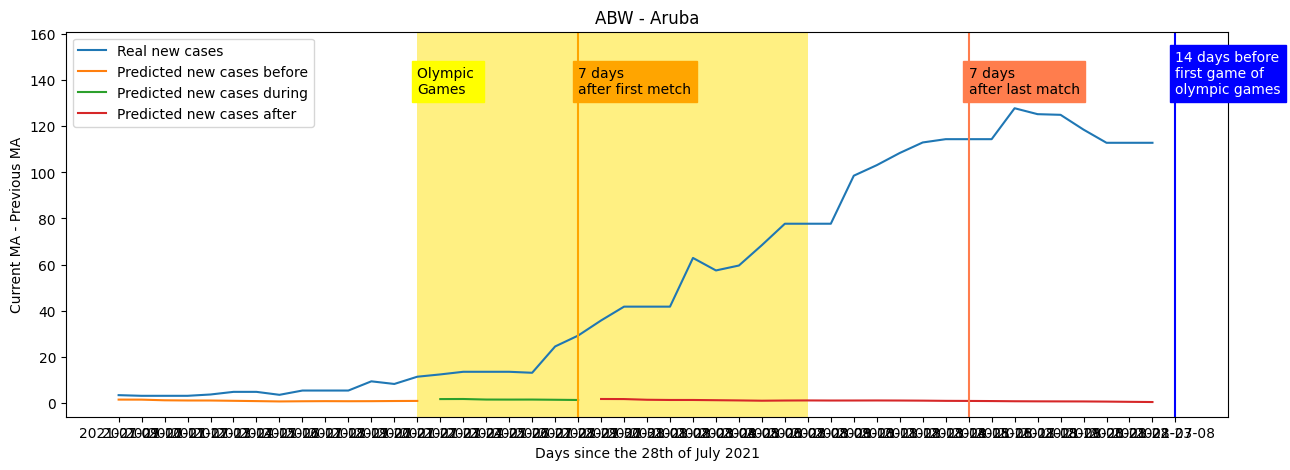

            moving_average_new_cases  moving_average_new_vaccinations
date                                                                 
2021-03-01                 16.571429                      1397.428571
2021-03-02                 16.142857                      1458.428571
2021-03-03                 15.142857                      1550.000000
2021-03-04                 13.571429                      1672.000000
2021-03-05                 18.714286                      1824.571429
...                              ...                              ...
2021-07-04               1504.000000                     13403.857143
2021-07-05               1455.142857                     12650.428571
2021-07-06               1472.285714                     11657.714286
2021-07-07               1480.285714                     10445.571429
2021-07-08               1413.857143                      9424.142857

[130 rows x 2 columns]
            moving_average_new_cases  moving_average_new_vaccinati

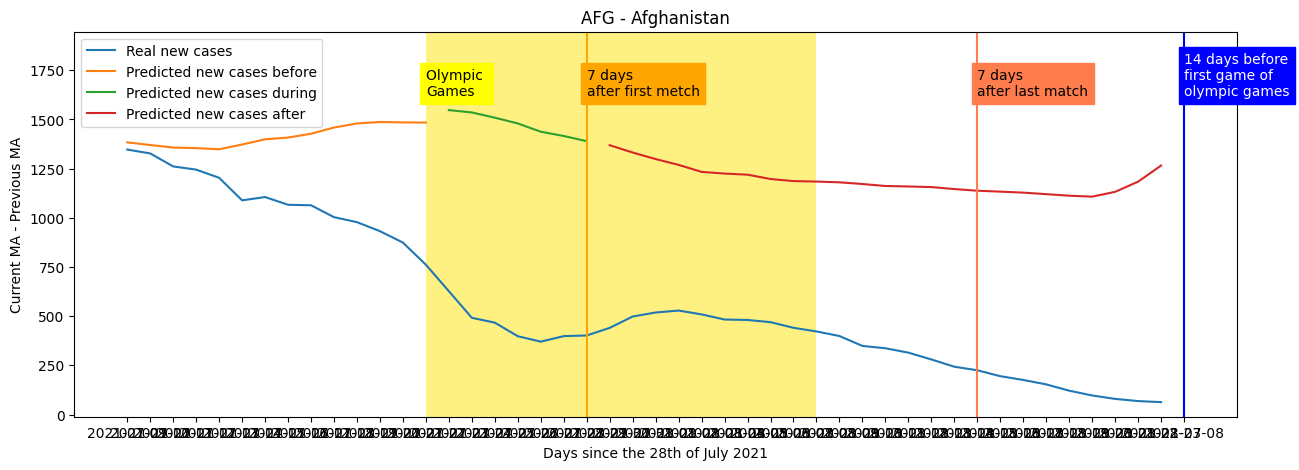

            moving_average_new_cases  moving_average_new_vaccinations
date                                                                 
2021-03-08                 39.857143                       881.000000
2021-03-09                 36.285714                       950.428571
2021-03-10                 33.142857                      1089.285714
2021-03-11                 34.000000                      1297.571429
2021-03-12                 32.000000                      1575.285714
...                              ...                              ...
2021-07-04                 92.000000                      9388.857143
2021-07-05                 96.285714                      7963.857143
2021-07-06                 98.142857                      6790.714286
2021-07-07                 99.000000                      5869.142857
2021-07-08                 91.714286                      5199.285714

[123 rows x 2 columns]
            moving_average_new_cases  moving_average_new_vaccinati

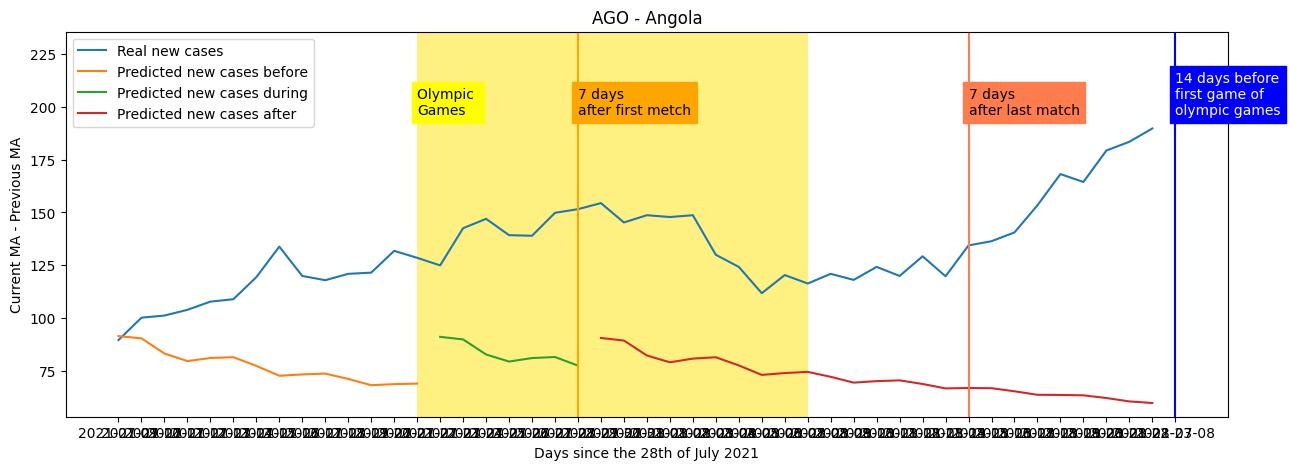

            moving_average_new_cases  moving_average_new_vaccinations
date                                                                 
2021-02-11                  0.142857                       149.000000
2021-02-12                  0.142857                       149.000000
2021-02-13                  0.142857                       149.000000
2021-02-14                  0.142857                       175.000000
2021-02-15                  0.142857                       199.857143
...                              ...                              ...
2021-07-04                  0.285714                        92.000000
2021-07-05                  0.285714                        91.428571
2021-07-06                  0.285714                        90.000000
2021-07-07                  0.285714                        87.714286
2021-07-08                  0.285714                        84.857143

[70 rows x 2 columns]
            moving_average_new_cases  moving_average_new_vaccinatio

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=174.352, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=171.446, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=174.044, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=174.364, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=169.450, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=172.902, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=172.761, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=172.687, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=173.017, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=171.088, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.695 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=208.557, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=207.518, Time=0.06 sec


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,2,0)(1,0,0)[4]             : AIC=160.320, Time=0.20 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=175.016, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=170.103, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=160.775, Time=0.20 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=161.261, Time=0.16 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=159.863, Time=0.09 sec
 ARIMA(1,2,0)(0,0,2)[4]             : AIC=161.088, Time=0.19 sec
 ARIMA(1,2,0)(1,0,2)[4]             : AIC=163.088, Time=0.25 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=208.776, Time=0.04 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=161.012, Time=0.11 sec
 ARIMA(1,2,1)(0,0,1)[4]             : AIC=160.976, Time=0.14 sec
 ARIMA(2,2,1)(0,0,1)[4]             : AIC=162.970, Time=0.27 sec
 ARIMA(1,2,0)(0,0,1)[4] intercept   : AIC=161.859, Time=0.13 sec

Best model:  ARIMA(1,2,0)(0,0,1)[4]          
Total fit time: 2.094 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=274.181, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=296.107, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=175.716, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=227.894, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=294.136, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=174.057, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=175.619, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=177.111, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=174.520, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=175.278, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=242.946, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=177.104, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=172.325, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=173.967, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[4]             : AIC=173.869, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[4]  

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

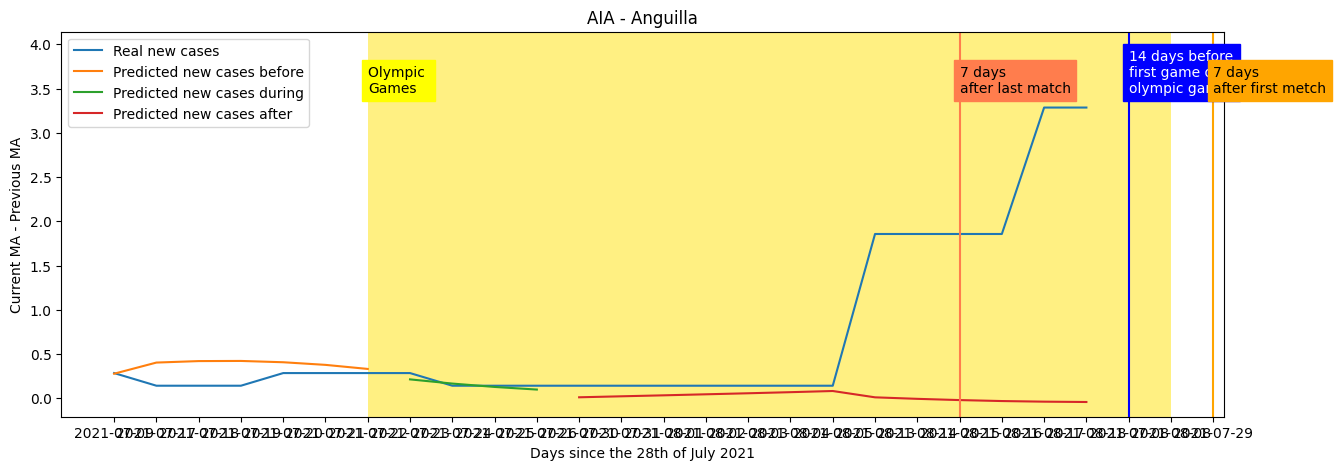

            moving_average_new_cases  moving_average_new_vaccinations
date                                                                 
2021-01-17                608.142857                        62.714286
2021-01-18                597.571429                        61.428571
2021-01-19                585.000000                        59.571429
2021-01-20                573.000000                        57.285714
2021-01-21                563.000000                        53.571429
...                              ...                              ...
2021-07-04                  2.857143                      7546.857143
2021-07-05                  3.571429                      7490.857143
2021-07-06                  3.285714                      7296.857143
2021-07-07                  3.428571                      6939.142857
2021-07-08                  4.285714                      6637.428571

[173 rows x 2 columns]
            moving_average_new_cases  moving_average_new_vaccinati

In [380]:
tabella = pd.DataFrame(columns=['State','FirstSlope','SecondSlope','ThirdSlope','FourthSlope'])
trend_negative = []
trend_positive = []
split_date = date(2021, 7, 8)

print(iso_code_list)

for code in iso_code_list:
    # STEP 1: crea un df con solo data e valore per ogni stato
    df_cases = pd.DataFrame(df_new_cases.loc[code]['moving_average_new_cases'].values, index = df_new_cases.loc[code]['moving_average_new_cases'].index, columns = ['moving_average_new_cases'])
    df_vaccin = pd.DataFrame(df_vaccination.loc[code]['moving_average_new_vaccinations'].values, index = df_vaccination.loc[code]['moving_average_new_vaccinations'].index, columns = ['moving_average_new_vaccinations'])
    
    # STEP 2: mergia i due df in uno solo
    merged_df = df_cases.merge(df_vaccin, on=['date'])
    merged_df.to_csv("./merged_df.csv")
    
    #find split date for df_vaccin that indicate first value not null of 0 for moving_average_new_vaccinations
    first_date = merged_df.loc[merged_df['moving_average_new_vaccinations'] > 0].index[0]
    last_date = str(split_date.strftime("%Y-%m-%d"))
    
    merged_df_train = merged_df.loc[(merged_df.index >= first_date) & (merged_df.index <= last_date)].copy()
    merged_df_test = merged_df.loc[merged_df.index > last_date].copy()
    
    print(merged_df_train)
    print(merged_df_test)
    
    
    best_model, best_pred, best_d, min_rmse = train_model(merged_df_train, merged_df_test)
    
    # STEP 4: crea un modello auto_ARIMA per predirre i new_cases considerando i vaccini fino 2 settimane prima dell'inizio delle olimpiadi
    model = pm.auto_arima(merged_df_train['moving_average_new_cases'], X=merged_df_train[["moving_average_new_vaccinations"]], start_p=0, start_q=0,
                                test='adf',       # use adftest to find optimal 'd'
                                max_p=3, max_q=3, # maximum p and q
                                d=best_d,          # let model determine 'd'
                                m=4,              # frequency of series
                                error_action='ignore',
                                suppress_warnings=True,
                                random_state=42,
                                maxiter=500, stationary=False,
                                trace=True,)
    
    length = len(merged_df_test)
    pred, ci = model.predict(n_periods=length, X=merged_df_test[["moving_average_new_vaccinations"]], alpha=0.05, return_conf_int=True)
    print("------------------")
    print(pred)
    print("------------------")
    
    #STEP 5: dividi il test set in 3 parti: 14 giorni prima, durante le olimpiadi e 14 giorni dopo    
    before_olympic = merged_df_test.loc[merged_df_test.index <= str(split_date + timedelta(days=14))].copy()
    during_olympic = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=14))) & (merged_df_test.index <= str(split_date + timedelta(days=21)))].copy()
    after_olympic = merged_df_test.loc[merged_df_test.index > str(split_date + timedelta(days=21))].copy()
    
    #STEP 6: predici i new_cases per le 3 parti del test set
    before_olympic_predicted = model.predict(n_periods=len(before_olympic), X=before_olympic[["moving_average_new_vaccinations"]])
    during_olympic_predicted = model.predict(n_periods=len(during_olympic), X=during_olympic[["moving_average_new_vaccinations"]])
    after_olympic_predicted = model.predict(n_periods=len(after_olympic), X=after_olympic[["moving_average_new_vaccinations"]])
    
    #STEP 7: calcola la media dei new_cases predetti per le 3 parti del test set
    before_olympic_mean_predicted = before_olympic_predicted.mean()
    during_olympic_mean_predicted = during_olympic_predicted.mean()
    after_olympic_mean_predicted = after_olympic_predicted.mean()
    
    #STEP 8: calcola la differenza tra la media dei new_cases predetti e la media dei new_cases reali per le 3 parti del test set
    before_olympic_difference = before_olympic_mean_predicted - before_olympic['moving_average_new_cases'].mean()
    during_olympic_difference = during_olympic_mean_predicted - during_olympic['moving_average_new_cases'].mean()
    after_olympic_difference = after_olympic_mean_predicted - after_olympic['moving_average_new_cases'].mean()
    
    #STEP 9: calcola la percentuale di differenza tra la media dei new_cases predetti e la media dei new_cases reali per le 3 parti del test set
    before_olympic_percentage_difference = (before_olympic_difference/before_olympic['moving_average_new_cases'].mean())*100
    during_olympic_percentage_difference = (during_olympic_difference/during_olympic['moving_average_new_cases'].mean())*100
    after_olympic_percentage_difference = (after_olympic_difference/after_olympic['moving_average_new_cases'].mean())*100
    
    #STEP 10: salva i risultati in un df
    row = pd.DataFrame.from_dict({'State': code, 'FirstSlope': before_olympic_percentage_difference, 'SecondSlope': during_olympic_percentage_difference, 'ThirdSlope': after_olympic_percentage_difference}, orient='index').T
    tabella = pd.concat([tabella, row], ignore_index=True)
    
    #STEP 11: plot the results
    plt.figure(figsize=(15,5))
    #plt.plot(before_olympic.index, before_olympic['moving_average_new_cases'], label = 'Real new cases')
    plt.plot(merged_df_test.index, merged_df_test['moving_average_new_cases'], label = 'Real new cases')
    plt.plot(before_olympic.index, before_olympic_predicted, label = 'Predicted new cases before')
    #plt.plot(during_olympic.index, during_olympic['moving_average_new_cases'], label = 'Real new cases')
    plt.plot(during_olympic.index, during_olympic_predicted, label = 'Predicted new cases during')
    #plt.plot(after_olympic.index, after_olympic['moving_average_new_cases'], label = 'Real new cases')
    plt.plot(after_olympic.index, after_olympic_predicted, label = 'Predicted new cases after')
    plt.title(code + " - " + df_new_cases.loc[code]['Country'].unique()[0])
    plt.legend()
    
    
    ymax = plt.ylim()[1]
    plt.ylim(ymax=ymax*1.20)
    
    plt.text(str(og_start_date + timedelta(days=-14)), ymax, "14 days before\nfirst game of\nolympic games", rotation=0, color="white", backgroundcolor="blue")
    plt.text(str(og_start_date), ymax, "Olympic \nGames", rotation=0, color="black", backgroundcolor="yellow")
    plt.text("2021-07-29", ymax, "7 days \nafter first metch", rotation=0, backgroundcolor="orange")
    plt.text(str(og_end_date + timedelta(days=7)), ymax, "7 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")
    
    plt.axvline(x = str(og_start_date + timedelta(days=-14) ), color = 'blue', label = '14 days before first game of olympic games')
    plt.axvspan(str(og_start_date), str(og_end_date), facecolor='#ffe206', alpha=0.5)
    plt.axvline(x = '2021-07-29', color = 'orange', label = '7 days after first game of olympic games')
    plt.axvline(x = str(og_end_date + timedelta(days=7)), color = '#FF7D4D', label = '7 days after last game of olympic games')
    
    plt.xlabel("Days since the 28th of July 2021")
    plt.ylabel("Current MA - Previous MA")
    
    #save the plot as a png file
    plt.savefig("../pictures/"+ code + "_intervals" +".png")
    plt.show()

'''    # Crea un plot con i punti di cambio colorati
    plt.title(code + " - " + df_new_cases.loc[code]['Country'].unique()[0])
    plt.axvline(x = difference.days-14, color = 'blue', label = '14 days before first game of olympic games')
    plt.axvline(x = difference.days+7, color = 'orange', label = '7 days after first game of olympic games')
    plt.axvline(x = difference.days+18, color = '#FF7D4D', label = '7 days after last game of olympic games')
    plt.xlabel("Days since the 28th of July 2021")
    plt.ylabel("Current MA - Previous MA")
    #plt.legend()
    plt.axvspan(difference.days, difference.days+11, facecolor='#ffe206', alpha=0.5)
    ymax = plt.ylim()[1]
    # aggiungi un margine di 5% sopra il massimo valore per far spazio alle etichette
    plt.ylim(ymax=ymax*1.20)
    plt.text(difference.days-14, ymax, "14 days before\nfirst game of\nolympic games", rotation=0, color="white", backgroundcolor="blue")
    plt.text(difference.days, ymax, "Olympic \nGames", rotation=0, color="black", backgroundcolor="yellow")
    plt.text(difference.days+7+1, ymax, "7 days \nafter first metch", rotation=0, backgroundcolor="orange")
    plt.text(difference.days+18+1, ymax, "7 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")
    #save the plot as a png file
    plt.savefig("../pictures/"+ code + "_intervals" +".png")
    plt.show()'''

In [ ]:
#tabella is the table for changepoints and tabella2 is the table for the intervals
tabella.set_index(tabella['State'])
tabella.to_csv("./tabella.csv", index=False)